# Анализирем все собранные данные, вытащим из них все акты настроки и посмотрим закономерности

In [43]:
import os
import math

from matplotlib import pyplot as plt

from load_serie import load_all_series
from denoize import create_denoized_spline, build_box_plot
from shot_detector import detect_shots

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Загрузка данных из всех доступных файлов в папке data

In [45]:
folder = 'data'

# найти все файлы .log в папке folder
files = [f for f in os.listdir(folder) if f.endswith('.log')]

global_series = []
for file in files:
    local_series = load_all_series(os.path.join(folder, file))
    
    count = 0
    for s in filter(lambda s: len(s) > 20, local_series):
        if s[0] != s[-1]:
            global_series.append(s)
            count += 1

    if count > 0:
        print(f'{file}: {count} series')

print(f'Всего {len(global_series)} серий')

freq_11-09-2023_08h-46m.log: 12 series
freq_11-09-2023_08h-50m.log: 91 series
freq_11-09-2023_11h-40m.log: 9 series
freq_11-09-2023_11h-47m.log: 11 series
freq_11-09-2023_11h-50m.log: 4 series
freq_11-09-2023_11h-54m.log: 1 series
freq_11-09-2023_12h-49m.log: 8 series
freq_11-09-2023_12h-54m.log: 14 series
freq_11-09-2023_12h-57m.log: 16 series
freq_11-09-2023_13h-05m.log: 35 series
freq_11-09-2023_13h-32m.log: 5 series
freq_11-09-2023_13h-38m.log: 2 series
freq_14-09-2023_08h-19m.log: 1 series
freq_14-09-2023_08h-50m.log: 4 series
freq_14-09-2023_08h-53m.log: 3 series
freq_14-09-2023_08h-54m.log: 3 series
freq_14-09-2023_08h-57m.log: 8 series
freq_14-09-2023_09h-01m.log: 3 series
freq_14-09-2023_09h-56m.log: 5 series
Всего 235 серий


Находим в данных все акты настройки и собираем их в один список

In [82]:
def move_to_zero(series: list[float]) -> list[float]:
    min_value = min(series)
    return [x - min_value for x in series]


def invalid_fragment(series: list[float]) -> bool:
    max_value = max(series)
    return max_value > 10.0 or series[0] >= series[-1]


def find_fragments_in_serie(serie: list[float], smooth: float = 0.1) -> list[float]:
    dns, _ = create_denoized_spline(serie, smooth)

    values_serie = [dns.Y(p.X) for p in dns.Points[:-2]]
    derivate_serie = [dns.dY(p.X) for p in dns.Points[:-2]]
    derivatire_bxplt = build_box_plot(derivate_serie)

    shots = list(detect_shots(derivate_serie, derivatire_bxplt['lower_bound'], derivatire_bxplt['upper_bound']))
    for shot_n in range(len(shots)):
        if shot_n == len(shots) - 1:
            fragment = values_serie[shots[shot_n]:]
        else:
            fragment = values_serie[shots[shot_n]:shots[shot_n+1]]
        
        zero_bazed_fragment = move_to_zero(fragment)
        if not invalid_fragment(zero_bazed_fragment):
            yield zero_bazed_fragment


def describe_fragment(serie: list[float], smooth: float = 0.1) -> dict[str, float]:
    dns, _s = create_denoized_spline(serie, smooth)

    values_serie = [dns.Y(i) for i in range(len(serie) - 1)]
    derivate_serie = [dns.dY(i) for i in range(len(serie) - 1)]
    derivatire_bxplt = build_box_plot(list(filter(lambda y: not math.isnan(y), derivate_serie)))

    shots = list(detect_shots(derivate_serie, derivatire_bxplt['lower_bound'], derivatire_bxplt['upper_bound']))
    yshots = [serie[i] for i in shots]

    _, ax = plt.subplots(1, 2)
    #ax[0, 0].plot(serie, 'bo', label='orignal values')
    ax[0].plot(values_serie, 'y-', label='smoothed values')
    ax[0].plot(shots, yshots, 'gd', label='shots')
    ax[1].plot(derivate_serie, 'r--',
             [0] * len(derivate_serie), 'b--',
             [derivatire_bxplt['lower_bound']] * len(serie), 'g--',
             [derivatire_bxplt['upper_bound']] * len(serie), 'g--')

Тест фрагментов
- 11
- 25 - нет скачка производной вниз
- 39 - большой кусок с множеством настроечных актов
- 40 - большой кусок с множеством настроечных актов
- 42 - большой кусок, но некоторые акты не распознаны, нет скачка производной вниз
- 45 - Почти все распознано корректно
- 161 - Приемлемо
- 162 - 50/50
- 163 - Хороший результат
- 165 - Почти ни чего не распознано
- 166 - 1 акт распознан каки должно быть

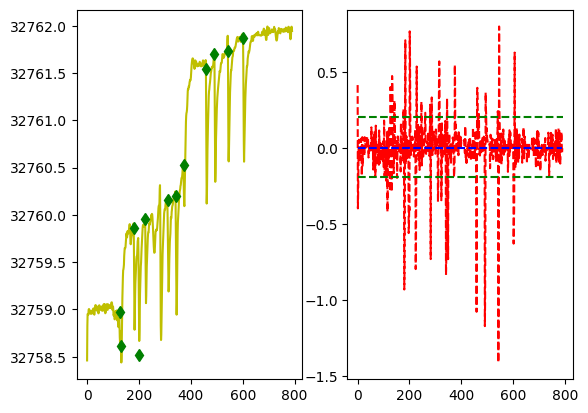

In [96]:
serie = global_series[162]

describe_fragment(serie)

In [11]:
fragments = list(find_fragments_in_serie(serie))

plt.plot(fragments[0])

IndexError: list index out of range

In [ ]:
global_fragments = []

for i, serie in enumerate(global_series):
    for fragment in find_fragments_in_serie(serie, 0.1):
        global_fragments.append(fragment)
        
print(f'Всего {len(global_fragments)} фрагментов')

Всего 483 фрагментов


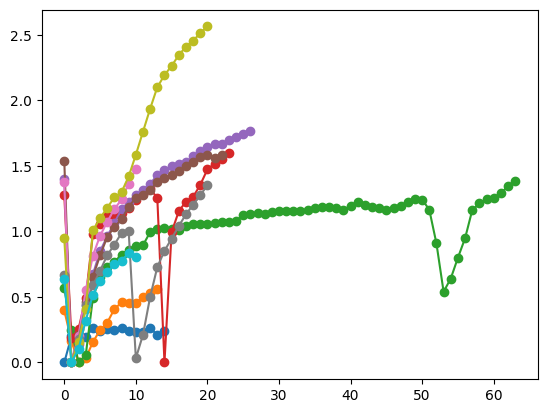

In [ ]:
for i, fragment in enumerate(global_fragments[:10]):
    plt.plot(fragment, 'o-')